### Word2vec embedding

In [ ]:
# tokenizing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

data['text'] = data['text'].apply(lambda x: x.lower()) # 소문자로
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x)) # 영문자 이외 문자 제거

word_tokens = []
for sentence in list(data.text):
  word_tokens.append(word_tokenize(str(sentence)))

# stopwords
stop_words = set(stopwords.words('english'))

result = []

for word in word_tokens:
  temp = []

  for i in range(len(word)):
    if len(word[i]) > 2: # 길이가 2 이하인 단어 제거
      if word[i] not in stop_words: # 불용어 제거
        temp.append(word[i])

  result.append(temp)

result = list(filter(None, result))

In [ ]:
# word2vec
from gensim.models.word2vec import Word2Vec

model = Word2Vec(result,        
                 sg=1,         
                 size=100,     
                 window=3,    
                 min_count=2,
                 workers=4,
                 iter=5)

In [ ]:
#model.save('word2vec.model')

In [110]:
from gensim.models import Word2Vec
model = Word2Vec.load('/content/drive/MyDrive/컨퍼런스/word2vec.model')
print(model.wv.most_similar("love", topn=5))
print(model.wv.most_similar("sad", topn=5))
print(model.wv.most_similar("girl", topn=5))

[('loves', 0.7376604080200195), ('loving', 0.6941666603088379), ('hate', 0.6874850988388062), ('luv', 0.6819210648536682), ('awesome', 0.6746213436126709)]
[('heartbroken', 0.8496648073196411), ('disappointed', 0.8112217783927917), ('fed', 0.794059157371521), ('upset', 0.7872953414916992), ('melancholy', 0.7856727838516235)]
[('boy', 0.8734229803085327), ('puppy', 0.8205183744430542), ('lady', 0.811775803565979), ('girls', 0.8107936382293701), ('sister', 0.8044112920761108)]


### LSTM model

In [111]:
# import packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [112]:
# data load
X_train = pd.read_csv("/content/drive/MyDrive/컨퍼런스/train_bert.csv").drop(columns="Unnamed: 0")
X_test = pd.concat([pd.read_csv("/content/drive/MyDrive/컨퍼런스/test_bert.csv").drop(columns="Unnamed: 0"),
                    pd.read_csv("/content/drive/MyDrive/컨퍼런스/val_bert.csv").drop(columns="Unnamed: 0")])
X_train.text = X_train.text.astype(str)
X_test.text = X_test.text.astype(str)

display(X_train.head())
display(X_test.head())

,text,anger,disgust,fear,joy,sadness,surprise,no emotion
0,i alternate between feeling embarrassed and ex...,0,0,0,0,1,0,0
1,What eye shadow do you think is the most fit f...,0,0,0,0,0,0,1
2,"Hello , can I speak to Alice , please ?",0,0,0,0,0,0,1
3,who are real name ? be specific which denomina...,0,0,0,0,0,1,0
4,im feeling cranky cantankerous and resentful l...,1,0,0,0,0,0,0


,text,anger,disgust,fear,joy,sadness,surprise,no emotion
0,"I can solve it , thanks .",0,0,0,1,0,0,0
1,im feeling a little apprehensive as we come ne...,0,0,1,0,0,0,0
2,wonder what name name thinks about all this,0,0,0,0,0,1,0
3,"Very well , thank you . And you ?",0,0,0,0,0,0,1
4,I wish I had time!! But its back to the airpor...,0,0,0,0,1,0,0


In [115]:
# text preprocessing
for data in [X_train, X_test]:
  data['text'] = data['text'].apply(lambda x: x.lower()) # 소문자로
  data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x)) # 영문자 이외 문자 제거

In [116]:
# train, test split
X_train, y_train = X_train['text'], X_train.copy().drop(columns='text').to_numpy()
X_test, y_test = X_test['text'], X_test.copy().drop(columns='text').to_numpy()

In [117]:
# preprocessing
token = Tokenizer()
token.fit_on_texts(list(X_train) + list(X_test))

X_train_pad = pad_sequences(token.texts_to_sequences(X_train), padding='pre', maxlen=200)
X_test_pad = pad_sequences(token.texts_to_sequences(X_test), padding='pre', maxlen=200)

In [118]:
# Word2vec embedding
vocab_size = len(token.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))

def get_vector(word):
    if word in model:
        return model[word]
    else:
        return None

for word, i in token.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

In [ ]:
print(model['nice'])

In [ ]:
print(embedding_matrix[token.word_index['nice']])

In [190]:
# LSTM modeling
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=X_train_pad.shape[1], trainable=False))
model.add(LSTM(100, dropout=0.2, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30, dropout=0.3))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 200, 100)          4415400   
_________________________________________________________________
lstm_98 (LSTM)               (None, 200, 100)          80400     
_________________________________________________________________
lstm_99 (LSTM)               (None, 200, 50)           30200     
_________________________________________________________________
lstm_100 (LSTM)              (None, 30)                9720      
_________________________________________________________________
dense_47 (Dense)             (None, 7)                 217       
Total params: 4,535,937
Trainable params: 120,537
Non-trainable params: 4,415,400
_________________________________________________________________
None


In [191]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
history = model.fit(X_train_pad, y_train, epochs=200, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
2703/2703 [==============================] - 118s 42ms/step - loss: 1.3085 - accuracy: 0.5445 - val_loss: 1.2094 - val_accuracy: 0.5808
Epoch 2/200
2703/2703 [==============================] - 77s 29ms/step - loss: 1.1890 - accuracy: 0.5846 - val_loss: 1.1256 - val_accuracy: 0.6101
Epoch 3/200
2703/2703 [==============================] - 78s 29ms/step - loss: 1.1185 - accuracy: 0.6129 - val_loss: 1.0659 - val_accuracy: 0.6418
Epoch 4/200
2703/2703 [==============================] - 77s 28ms/step - loss: 1.0677 - accuracy: 0.6338 - val_loss: 1.0152 - val_accuracy: 0.6580
Epoch 5/200
2703/2703 [==============================] - 77s 28ms/step - loss: 1.0366 - accuracy: 0.6461 - val_loss: 0.9752 - val_accuracy: 0.6821
Epoch 6/200
2703/2703 [==============================] - 76s 28ms/step - loss: 1.0130 - accuracy: 0.6587 - val_loss: 0.9618 - val_accuracy: 0.6842
Epoch 7/200
2703/2703 [==============================] - 77s 28ms/step - loss: 0.9915 - accuracy: 0.6654 - val_loss: 

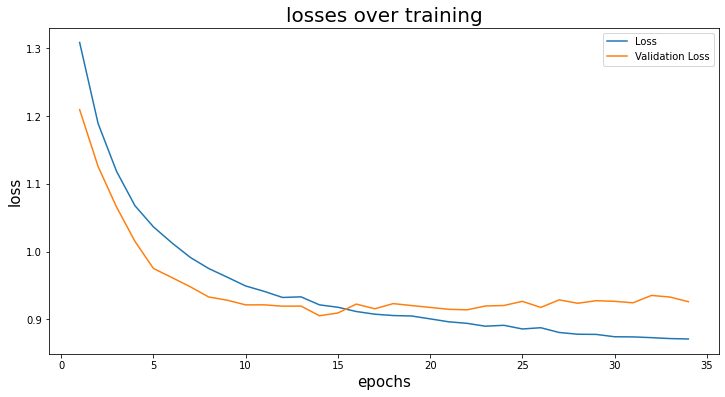

In [192]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(34)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(34)+1, history.history['val_loss'], label='Validation Loss')
plt.title('losses over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

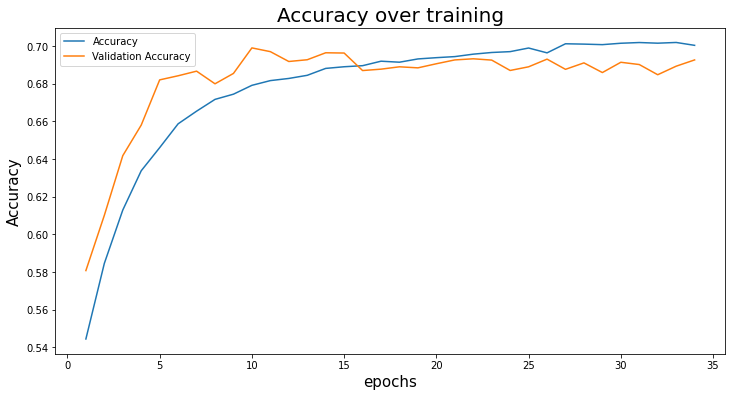

In [193]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(34)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(34)+1, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.legend()
plt.show()

In [198]:
from tensorflow import keras
#model = keras.models.load_model("/content/drive/MyDrive/컨퍼런스/model.h5")
model.save("model_new_2.h5")

In [194]:
# predict
emotion = model.predict(X_test_pad)
emo = np.round(emotion)

sent_to_emotion = {0:'anger', 1:'disgust', 2:'fear', 3:'joy', 4:'sadness', 5:'surprise', 6:'no emotion'}

x = []
for i in range(len(emo)):
    x.append(np.argmax(emo[i]))

actual = []
for i in range(len(y_test)):
    actual.append(np.argmax(y_test[i]))

In [195]:
result_data = pd.DataFrame({"Text": copy['text'].reset_index(drop=True), "Actual": pd.Series(actual).map(sent_to_emotion),
                            "Predict": pd.Series(x).map(sent_to_emotion)})
result_data.head(20)

,Text,Actual,Predict
0,"I can solve it , thanks .",joy,joy
1,im feeling a little apprehensive as we come ne...,fear,fear
2,wonder what name name thinks about all this,surprise,anger
3,"Very well , thank you . And you ?",no emotion,joy
4,I wish I had time!! But its back to the airpor...,sadness,sadness
5,i too feel a sense of melancholy for them,sadness,sadness
6,i love that you have such a great relationship...,joy,joy
7,on top of being cheaper and a better power cur...,no emotion,anger
8,Of course .,joy,anger
9,i feel like shes losing her sense of self to a...,joy,joy


In [196]:
n = 0
for i in range(len(result_data)):
  if result_data['Actual'][i] == result_data['Predict'][i]:
    n += 1

print((n / len(result_data)) * 100)

63.239483517703206


In [197]:
# input textt
text = []
text.append(str(input("텍스트를 영어로 입력하세요: ")))
token.fit_on_texts(text)
text_pre = pad_sequences(token.texts_to_sequences(text), padding='pre', maxlen=200)
pre = model.predict(text_pre)
print("해당 텍스트의 감정은 " + pd.Series(np.argmax(np.round(pre))).map(sent_to_emotion) + " 입니다.")

텍스트를 영어로 입력하세요: I love you
0    해당 텍스트의 감정은 joy 입니다.
dtype: object
